## Importing required functions

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Scrapping data from target website:

In [10]:

data = requests.get('https://www.iiserkol.ac.in/web/en/people/faculty/dbs/')
soup = BeautifulSoup(data.content, "html.parser")

urls = [link['href'] for link in soup.find_all('a')]
urls = [url for url in urls if '/web/en/people/faculty/dbs/' in url]
link = 'https://www.iiserkol.ac.in'
faculty_websites = list(set([link + url for url in urls]))

all_data = []

for faculty_url in faculty_websites:
    data = requests.get(faculty_url)
    soup = BeautifulSoup(data.content, "html.parser")

    name = soup.find_all('h3')
    faculty_name = [name.text for name in name]
    faculty_name = faculty_name[3] if faculty_name else ''

    content = soup.find_all('div', class_='col-md-12 innerdiv')
    profile_data = {
        "Name": faculty_name,
        "Research Interest": None,
        "Academic Background": None,
        "PhD": None,
        "PhD Year": None,
        "Positions": None,
        "Awards and Honors": None,
        "Number of awards": None,
        "Publications": None,
        "Number of publications":num_of_pubs,
    }

    for section in content:
        section_text = section.text

        if 'Research Interest:' in section_text:
            profile_data["Research Interest"] = re.sub(r'Research Interest:\s+', '', section_text)

        elif 'Academic Background:' in section_text:
            profile_data["Academic Background"] = re.sub(r'Academic Background:\s+', '', section_text)
            c = re.search(r"\d", section_text)
            if c:
                x = c.start()
                profile_data["PhD Year"] = section_text[x:x+4]
            if 'PhD' in section_text or 'phd' in section_text or 'Ph.D' in section_text or 'Ph.D.' in section_text:
                profile_data["PhD"] = section_text[21:x-1]

        elif 'Positions:' in section_text:
            profile_data["Positions"] = re.sub(r'Positions:\s+', '', section_text)

        elif 'Awards and Honors:' in section_text:
            profile_data["Awards and Honors"] = re.sub(r'Awards and Honors:\s+', '', section_text)
            profile_data["Number of awards"] = (section_text.count('20') + section_text.count('19')
                                                -section_text.count('2020')-section_text.count('2019'))
            
    pubs=soup.find_all('a','p1')
    
    for i in pubs:
        pubs_link=(i['href'])
        pubs_link=[faculty_url+'/'+pubs_link]

        for i in pubs_link:
            data = requests.get(i)
            soup = BeautifulSoup(data.content, "html.parser")
            all_pubs=soup.find_all(class_='col-md-12 innerdiv')
            publications= [all_pubs.text for all_pubs in all_pubs]

            years=[str(years)for years in range (1901,2026)]
            years=[years+'."' for years in years]

            num_of_pubs=0

            pubs_str = " ".join(publications)
            profile_data["Publications"] = re.sub(r'All Publications:\s+', '', pubs_str)
            
            for year in years:
                num_of_pubs += pubs_str.count(year)
                

    all_data.append(profile_data)
    print(profile_data)



{'Name': 'Partha Pratim Datta', 'Research Interest': 'We are trying to understand the action mechanisms of an essential bacterial GTPase protein CgtA (Obg) that is a new drug target against increasing antimicrobial resistance (AMR) in different bacteria. For this we use various Molecular Biological, Biochemical, Microbiological, Structural Biological and Computational tools. We are studying molecular basis of Anti Microbial Resistance (AMR) and action mechanisms of several novel proteins recently discovered in our lab. On the other hand, we are also doing structure function study (cryo-EM) of certain plant viruses that cause huge economic loss in India and in the world.', 'Academic Background': 'PhD (Molecular Biology), IICB (Jadavpur University), 2002MSc (Biotechnology) (Biotechnology, Molecular Biology, Plant Molecular Biology, Microbiology), MKU, 1995BSc(Ag) Hons (Biochemistry, Genetics, Agril. Chemistry), BCKV, 1993', 'PhD': 'PhD (Molecular Biology), IICB (Jadavpur University),', '

## Creating a Database:

In [12]:
conn = sqlite3.connect("faculty_data.db")
cursor = conn.cursor()

cursor.execute("DROP TABLE IF EXISTS Faculty")

cursor.execute('''
    CREATE TABLE Faculty (
        Name TEXT,
        Research_Interest TEXT,
        Academic_Background TEXT,
        PhD TEXT,
        PhD_Year INTEGER,
        Positions TEXT,
        Awards_and_Honors TEXT,
        Number_of_awards INTEGER,
        Publications TEXT,
        No_of_publications INTEGER
    
    )
''')

for profile in all_data:
    cursor.execute('''
        INSERT INTO Faculty (
            Name, Research_Interest, Academic_Background, PhD, PhD_Year,
            Positions, Awards_and_Honors, Number_of_awards, Publications, No_of_publications
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    ''', (
        profile["Name"],
        profile["Research Interest"],
        profile["Academic Background"],
        profile["PhD"],
        profile["PhD Year"],
        profile["Positions"],
        profile["Awards and Honors"],
        profile["Number of awards"],
        profile["Publications"],
        profile["Number of publications"]
    ))

conn.commit()

df = pd.read_sql_query("SELECT * FROM Faculty", conn)

conn.close()

In [13]:
df

,Name,Research_Interest,Academic_Background,PhD,PhD_Year,Positions,Awards_and_Honors,Number_of_awards,Publications,No_of_publications
0,Partha Pratim Datta,We are trying to understand the action mechani...,"PhD (Molecular Biology), IICB (Jadavpur Univer...","PhD (Molecular Biology), IICB (Jadavpur Univer...",2002.0,"Associate Professor, IISER Kolkata (curre...",Robert J. Colinas Award for Outstanding Postdo...,2.0,"Basu Mallick, Sritapa; Das, Sagarika; Venkatas...",30
1,Sreeramaiah Gangappa,"The ability to perceive, integrate, and proces...","PhD (Plant Molecular Biology), NIPGR (JNU, New...","PhD (Plant Molecular Biology), NIPGR (JNU, New...",2009.0,"Assistant Professor, IISER Kolkata ( - )Marie-...",Ramalingaswami Re-entry Felloship from Departm...,2.0,"Gangappa, Sreeramaiah N and Kumar, S Vinod. 20...",20
2,Annagiri Sumana,EvolutionEcologyAnimal Behaviour,"PhD (Dominance Hierarchy in a social wasp), In...","PhD (Dominance Hierarchy in a social wasp), In...",2002.0,"Professor, IISER Kolkata ( - )Chairman - Depar...",Emerging nations award from Animal Behaviour S...,4.0,"Kolay, Swetashree and Sumana, Annagiri. 2015.""...",5
3,Sumit Sen Santara,Innate immune cells evolve early and are prese...,"Ph.D. (Biochemistry), Indian Institute of chem...","Ph.D. (Biochemistry), Indian Institute of chem...",2014.0,"Assistant Professor, IISER Kolkata (curre...",INSA Young Scientist Award from Indian Nationa...,5.0,"Santara, Sumit Sen; Crespo, Angela C; Lee, Dia...",10
4,Neelanjana Sengupta,The key goal of our research is to understand ...,"Ph.D (Chemical and Materials Physics), UCI (Un...","Ph.D (Chemical and Materials Physics), UCI (Un...",2008.0,"Associate Professor, IISER Kolkata ( - )Assist...",None,NaN,"Menon, Sneha and Sengupta, Neelanjana. 2019.""T...",15
5,Amirul Islam Mallick,My research focuses on studying host-pathogen ...,"PhD (Biotechnology), Interdisciplinary Biotech...","PhD (Biotechnology), Interdisciplinary Biotech...",2008.0,"Associate Professor, IISER Kolkata (curre...",Scientific High Level Visiting Fellowships (SS...,11.0,"Saha, Ekta; Khan, Afruja; Mallick*, Amirul I a...",3
6,Sankar Maiti,Regulation of Actin Cytoskeleton,"PhD (Biology), IMTECH, Chandigarh (Punjab Univ...","PhD (Biology), IMTECH, Chandigarh (Punjab Univ...",2003.0,"Associate Professor, IISER Kolkata ( - )Postdo...",None,NaN,"Dutta, Priyanka; AS, Jijumon; Mazumder, Mohit;...",56
7,Bidisha Sinha,The theme of the lab is to understand how cell...,"PhD (Life Sciences), National Centre for Biolo...","PhD (Life Sciences), National Centre for Biolo...",2007.0,"Associate Professor, IISER Kolkata (curre...",Intermediate Fellowship from Wellcome Trust DB...,2.0,"Chakraborty, Madhura; Sivan, Athul; Biswas, Ar...",3
8,Robert John Chandran,We conduct ecological research at the populati...,"PhD (Tropical Forest Ecology), Centre for Ecol...","PhD (Tropical Forest Ecology), Centre for Ecol...",2001.0,"Associate Professor, IISER Kolkata (curre...",None,NaN,"Zhang, Hui; Li, Yousheng; Xu, Yihui and John, ...",7
9,Jayasri Das Sarma,My laboratory is involved in the study of neur...,"PhD (Immunology/Biochemistry), Indian Statisti...","PhD (Immunology/Biochemistry), Indian Statisti...",1995.0,"Professor, IISER Kolkata ( - )Adjunct Associat...",ASMCUE Leadership Award for International Educ...,7.0,"Basu, Rahul; Bose, Abhishek; Thomas, Deepthi a...",11


# Data Analysis

#### Location of PhD:
Sample Data Obtained for Places in India

In [16]:
Indian_cities= ["India", "Indian", "National", "national" "Andhra Pradesh", "Arunachal Pradesh", "Assam", "Bihar", 
                    "Chhattisgarh", "Goa", "Gujarat", "Haryana", "Himachal Pradesh", 
                    "Jharkhand", "Karnataka", "Kerala", "Madhya Pradesh", "Maharashtra", "Manipal"
                    "Manipur", "Meghalaya", "Mizoram", "Nagaland", "Odisha", "Punjab", "Ropar"
                    "Rajasthan", "Sikkim", "Tamil Nadu", "Telangana", "Tripura", "Uttar Pradesh", "Kharagpur"
                    "Uttarakhand", "West Bengal", "Andaman and Nicobar Islands", "Chandigarh", "Bombay", "Madras"
                    "Dadra and Nagar Haveli and Daman and Diu", "Lakshadweep", "Delhi", "Puducherry","Dharwad"
                    "Ladakh", "Jammu and Kashmir""New Delhi", "Mumbai", "Bengaluru", "Hyderabad", "Chennai", 
                    "Kolkata", "Ahmedabad", "Pune", "Jaipur", "Surat", "Lucknow", "Kanpur", "Nagpur", "Visakhapatnam",
                    "Bhopal", "Patna", "Vadodara", "Ghaziabad", "Ludhiana", "Agra", "Nashik", "Faridabad", "Meerut", 
                    "Rajkot", "Kalyan-Dombivli", "Vasai-Virar", "Varanasi", "Srinagar", "Aurangabad", "Dhanbad",
                    "Amritsar", "Navi Mumbai", "Allahabad", "Howrah", "Ranchi", "Gwalior", "Jabalpur", "Coimbatore",
                    "Vijayawada", "Jodhpur", "Madurai", "Raipur", "Kota", "Guwahati", "Chandigarh", "Solapur", 
                    "Hubli-Dharwad", "Bareilly", "Mysuru", "Tiruchirappalli", "Tiruppur", "Salem", "Aligarh", "Calcutta"
                    "Thiruvananthapuram", "Bhiwandi", "Saharanpur", "Gorakhpur", "Guntur", "Bikaner", "Amravati", 
                    "Noida", "Jamshedpur", "Bhilai", "Cuttack", "Firozabad", "Kochi", "Bhavnagar", "Dehradun", 
                    "Durgapur", "Asansol", "Nanded", "Kolhapur", "JNU", "Ajmer", "Akola", "Gulbarga", "Jamnagar", "Ujjain",
                    "Loni", "Siliguri", "Jhansi", "Ulhasnagar", "Sangli", "Belgaum", "Mangalore", "Ambattur", 
                    "Tirunelveli", "Malegaon", "Gaya", "Jalgaon", "Udaipur", "Maheshtala", "Davanagere", "Kozhikode", 
                    "Kurnool", "Rajahmundry", "Bokaro", "South Dumdum", "Bellary", "Patiala", "Agartala", "Bhagalpur", 
                    "Muzaffarnagar", "Bhatpara", "Panihati", "Latur", "Dhule", "Rohtak", "Korba", "Bhilwara", "Brahmapur", 
                    "Muzaffarpur", "Ahmednagar", "Mathura", "Kollam", "Avadi", "Kadapa", "Anantapur", "Bilaspur", 
                    "Sambalpur", "Shahjahanpur", "Satara", "Bijapur", "Rampur", "Shimoga", "Chandrapur", "Junagadh", 
                    "Thrissur", "Alwar", "Bardhaman", "Kulti", "Nizamabad", "Parbhani", "Tumkur", "Khammam", "Uzhavarkarai",
                    "Bihar Sharif", "Panipat", "Darbhanga", "Bally", "Aizawl", "Dewas", "Ichalkaranji", "Tirupati", 
                    "Karnal", "Bathinda", "Jalna", "Eluru", "Barasat", "Purnia", "Satna", "Mau", "Sonipat", "Farrukhabad",
                    "Sagar", "Rourkela", "Durg", "Imphal", "Ratlam", "Hapur", "Arrah", "Jadavpur","Karimnagar", "Anand",
                    "Moradabad", "Bhiwani", "Baramulla", "Puducherry", "Adoni", "Jamui", "Gopalganj", "Malda"]

In [17]:
"""
Sorting the Faculty Members Based on Indian/Abroad Institutes
"""

def institution(phd_string):
    if phd_string is None:
        return None  
    for institute in Indian_cities:
        if institute in str(phd_string):
            return "India"
    return "Abroad"

df['PhD_Institution'] = df['PhD'].apply(institution)


#### Relevant plots


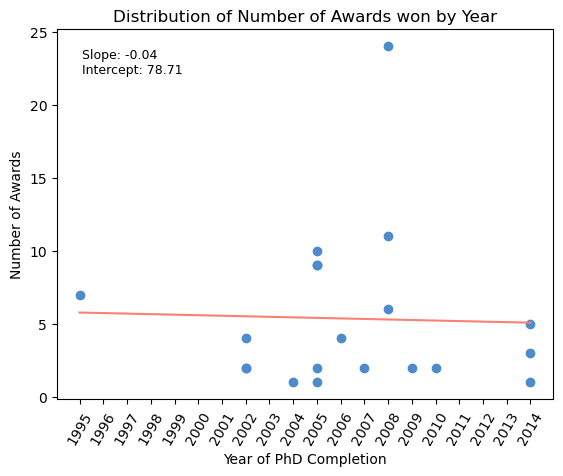

In [ ]:
'''Year of Phd completion vs Number of awards won'''

def linfunc(x,a,b):
    return a*x + b

def plotuh(x, y, xlabel, ylabel):
    plt.scatter(x, y, color='#4e8bcc')
    popt, pcov = curve_fit(linfunc, x, y)

    xdata = np.arange(int(min(x)), int(max(x)) + 1)
    plt.plot(xdata, linfunc(xdata, *popt), color='salmon')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=60)
    plt.xticks(xdata)  
    slope = round(popt[0], 2)
    intercept = round(popt[1], 2)
    plt.text(0.05, 0.95, f"Slope: {slope}\nIntercept: {intercept}", 
             transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', color='black')
    plt.title("Distribution of Number of Awards won by Year")

    plt.show()


df_yrAw = df.dropna(subset=["Number_of_awards"])
years = df_yrAw["PhD_Year"]
Aws = df_yrAw["Number_of_awards"]

plotuh(years, Aws, "Year of PhD Completion", "Number of Awards")
    

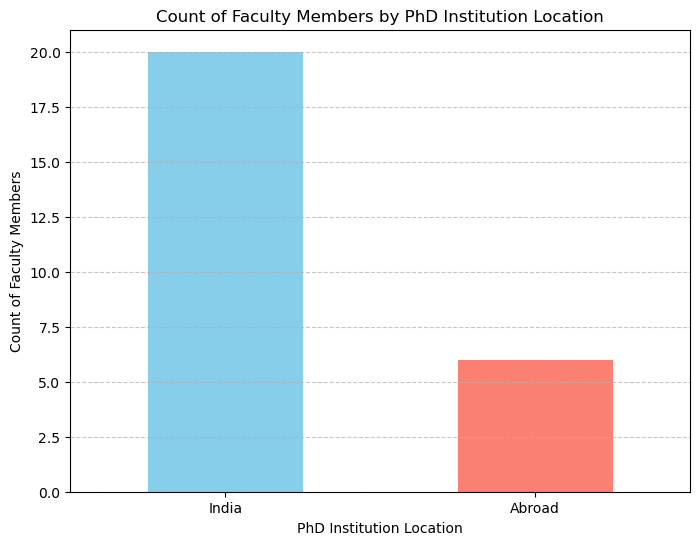

In [ ]:
'''Location of PhD vs Number of faculty'''

phd_counts = df['PhD_Institution'].value_counts()
plt.figure(figsize=(8, 6))
phd_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel("PhD Institution Location")

plt.ylabel("Count of Faculty Members")
plt.title("Count of Faculty Members by PhD Institution Location")
plt.xticks(rotation=0)  
plt.show()

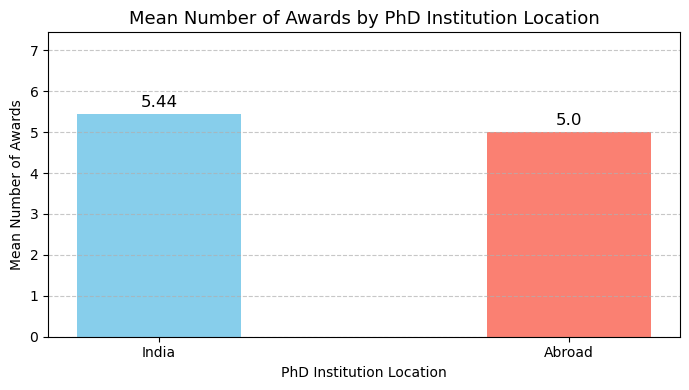

In [ ]:
'''Location of PhD Vs Mean number of awards won'''

df_filtered = df[df['PhD_Institution'].notna()]

mean_awards = df_filtered.groupby('PhD_Institution')['Number_of_awards'].mean()

mean_awards_india = mean_awards.get('India', 0)  
mean_awards_abroad = mean_awards.get('Abroad', 0)  

labels = ['India', 'Abroad']
mean_values = [mean_awards_india, mean_awards_abroad]

plt.figure(figsize=(7, 4))

bars = plt.bar(labels, mean_values, color=['skyblue', 'salmon'], width=0.4)

plt.title('Mean Number of Awards by PhD Institution Location', fontsize=13)
plt.xlabel('PhD Institution Location', fontsize=10)
plt.ylabel('Mean Number of Awards', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, max(mean_values) + 2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

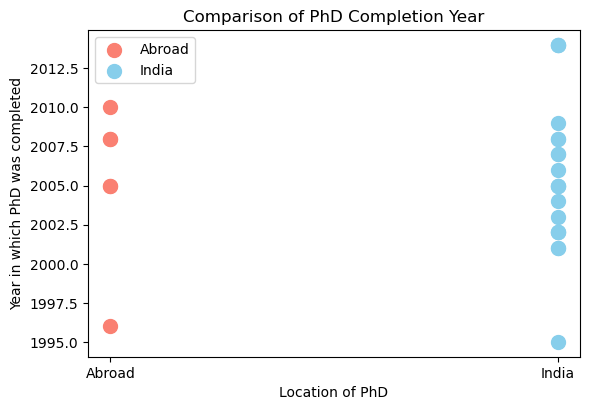

In [30]:
'''Distribution of PhD completion year and location'''

df_filtered = df[df['PhD_Institution'].notna()]

abroad = df_filtered['PhD_Institution'] == 'Abroad'

plt.figure(figsize=(6, 4))

plt.scatter(df_filtered[abroad]['PhD_Institution'], df_filtered[abroad]['PhD_Year'], 
            s=100, color='salmon', label='Abroad')

plt.scatter(df_filtered[~abroad]['PhD_Institution'], df_filtered[~abroad]['PhD_Year'], 
            s=100, color='skyblue', label='India')

plt.xlabel('Location of PhD')
plt.ylabel('Year in which PhD was completed')
plt.tight_layout()
plt.title("Comparison of PhD Completion Year")
plt.legend()

plt.show()

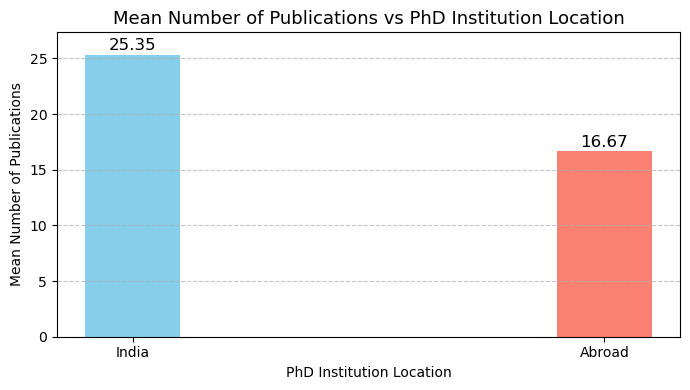

In [20]:
'''Location of PhD vs Average number of publications'''

df_filtered = df[df['PhD_Institution'].notna()]

mean_pubs = df_filtered.groupby('PhD_Institution')['No_of_publications'].mean()

mean_pubs_india = mean_pubs.get('India', 0)  
mean_pubs_abroad = mean_pubs.get('Abroad', 0)  

labels = ['India', 'Abroad']
mean_values = [mean_pubs_india, mean_pubs_abroad]

plt.figure(figsize=(7, 4))

bars = plt.bar(labels, mean_values, color=['skyblue', 'salmon'], width=0.2)

plt.title('Mean Number of Publications vs PhD Institution Location', fontsize=13)
plt.xlabel('PhD Institution Location', fontsize=10)
plt.ylabel('Mean Number of Publications', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, max(mean_values) + 2)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()



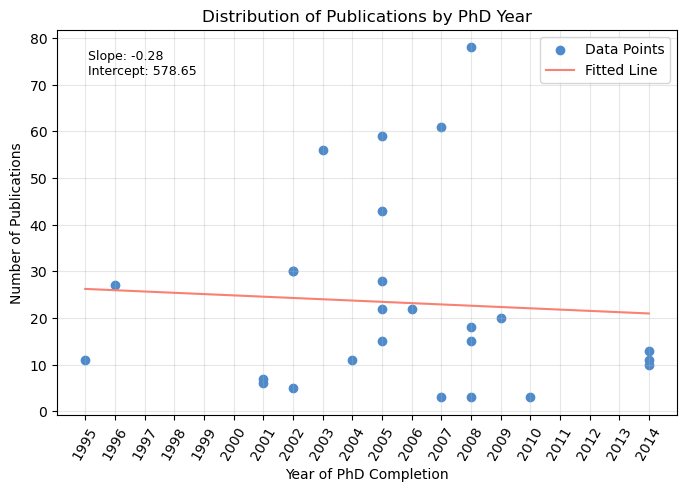

In [ ]:
'''Number of publications vs year of PhD completion'''

def linfunc(x, a, b):
    return a * x + b

def plotuh(x, y, xlabel, ylabel, title="Distribution of Publications by PhD Year", color='#4e8bcc'):
    plt.figure(figsize=(8, 5))
    plt.scatter(x, y, color=color, label="Data Points")
    
    popt, pcov = curve_fit(linfunc, x, y)
    
    x_data = np.arange(int(min(x)), int(max(x)) + 1)
    plt.plot(x_data, linfunc(x_data, *popt), color='salmon', label="Fitted Line")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=60)
    plt.xticks(x_data)  
    plt.grid(alpha=0.3)
    
    slope = round(popt[0], 2)
    intercept = round(popt[1], 2)
    plt.text(0.05, 0.95, f"Slope: {slope}\nIntercept: {intercept}", 
             transform=plt.gca().transAxes, fontsize=9, verticalalignment='top', color='black')
    
    plt.title(title)
    plt.legend()
    plt.show()


df_yrPub = df.dropna(subset=["No_of_publications", "PhD_Year"])  

df_yrPub = df_yrPub.dropna(subset=["PhD_Year", "No_of_publications"])
phdyear = df_yrPub["PhD_Year"]
nop = df_yrPub["No_of_publications"]

plotuh(phdyear, nop, "Year of PhD Completion", "Number of Publications")
